In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

In [3]:
data = pd.read_csv('E:/jupyter/机器学习项目/红酒质量-svm/winequality-red.csv')

In [5]:
outliers_indexes = []
target = 'quality'
for col in data.columns:
    q1 =  data[col].quantile(0.25)
    q3 =  data[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples =  data[( data[col] < minimum) | ( data[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())

# 去重并输出结果   
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

420 outliers were identified, whose indices are:

[9, 11, 13, 14, 15, 17, 18, 19, 33, 35, 38, 39, 40, 42, 43, 45, 55, 57, 64, 65, 79, 81, 83, 86, 88, 90, 91, 92, 94, 95, 106, 109, 120, 125, 126, 127, 130, 134, 142, 144, 145, 147, 151, 154, 155, 156, 157, 161, 163, 164, 169, 181, 188, 189, 190, 192, 199, 201, 205, 206, 210, 215, 219, 226, 240, 243, 244, 258, 264, 267, 268, 269, 270, 271, 272, 274, 275, 276, 277, 278, 279, 281, 283, 291, 294, 303, 307, 308, 313, 324, 325, 326, 327, 328, 330, 331, 335, 338, 339, 340, 347, 353, 354, 359, 363, 364, 366, 368, 369, 372, 374, 375, 376, 377, 378, 381, 390, 391, 394, 395, 396, 400, 408, 409, 413, 415, 417, 418, 429, 440, 442, 446, 447, 451, 455, 459, 463, 467, 470, 472, 477, 480, 481, 482, 483, 484, 494, 495, 497, 498, 501, 502, 503, 504, 506, 509, 510, 512, 515, 516, 517, 522, 523, 538, 539, 541, 544, 548, 549, 553, 554, 555, 556, 557, 558, 559, 560, 564, 565, 566, 567, 568, 584, 586, 588, 591, 595, 596, 599, 601, 603, 606, 608, 611, 614, 618, 

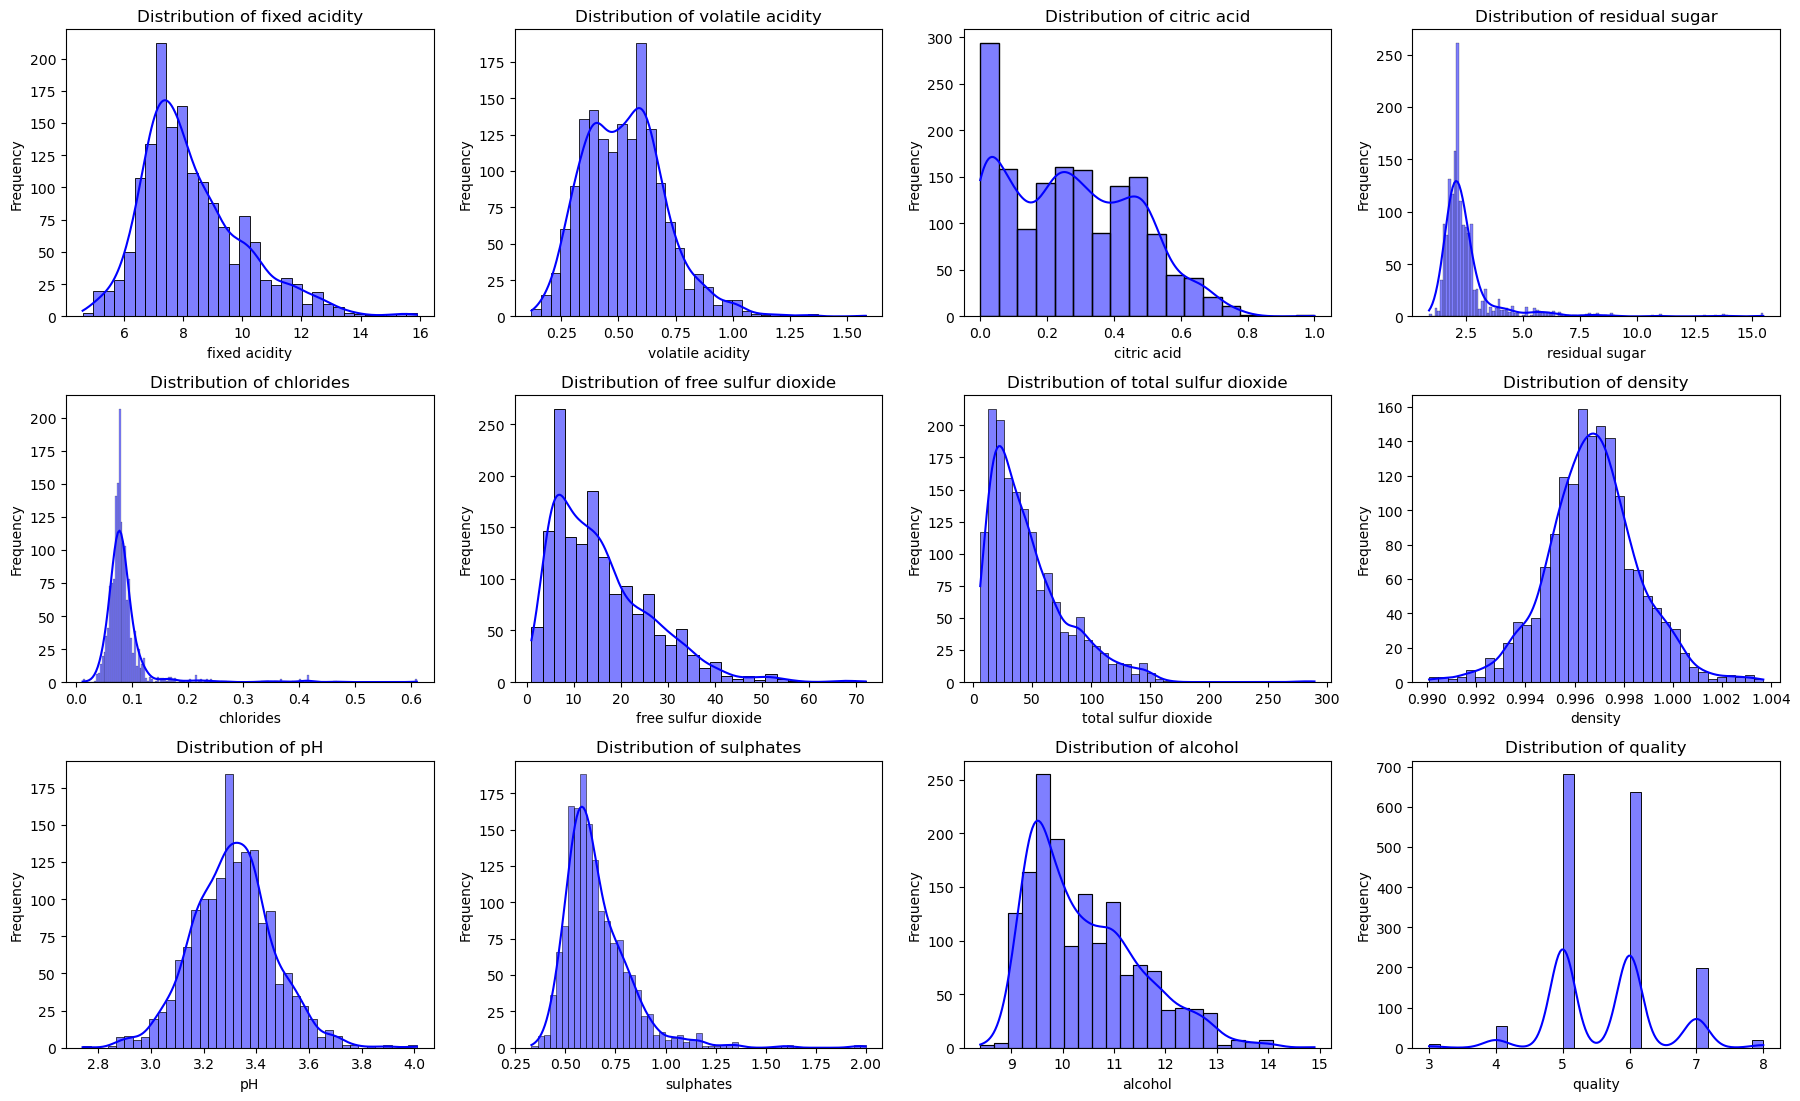

In [9]:
numeric_features = data.columns
plt.figure(figsize=(18, 18))

# 绘制每个特征的直方图和核密度估计曲线
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(5, 4, i)  # 假设最多显示16个特征，你可以根据实际需要调整
    sns.histplot(data[feature], kde=True, bins='auto', color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')
# 调整布局以防止标签重叠
plt.savefig("红酒质量-特征分布图.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()

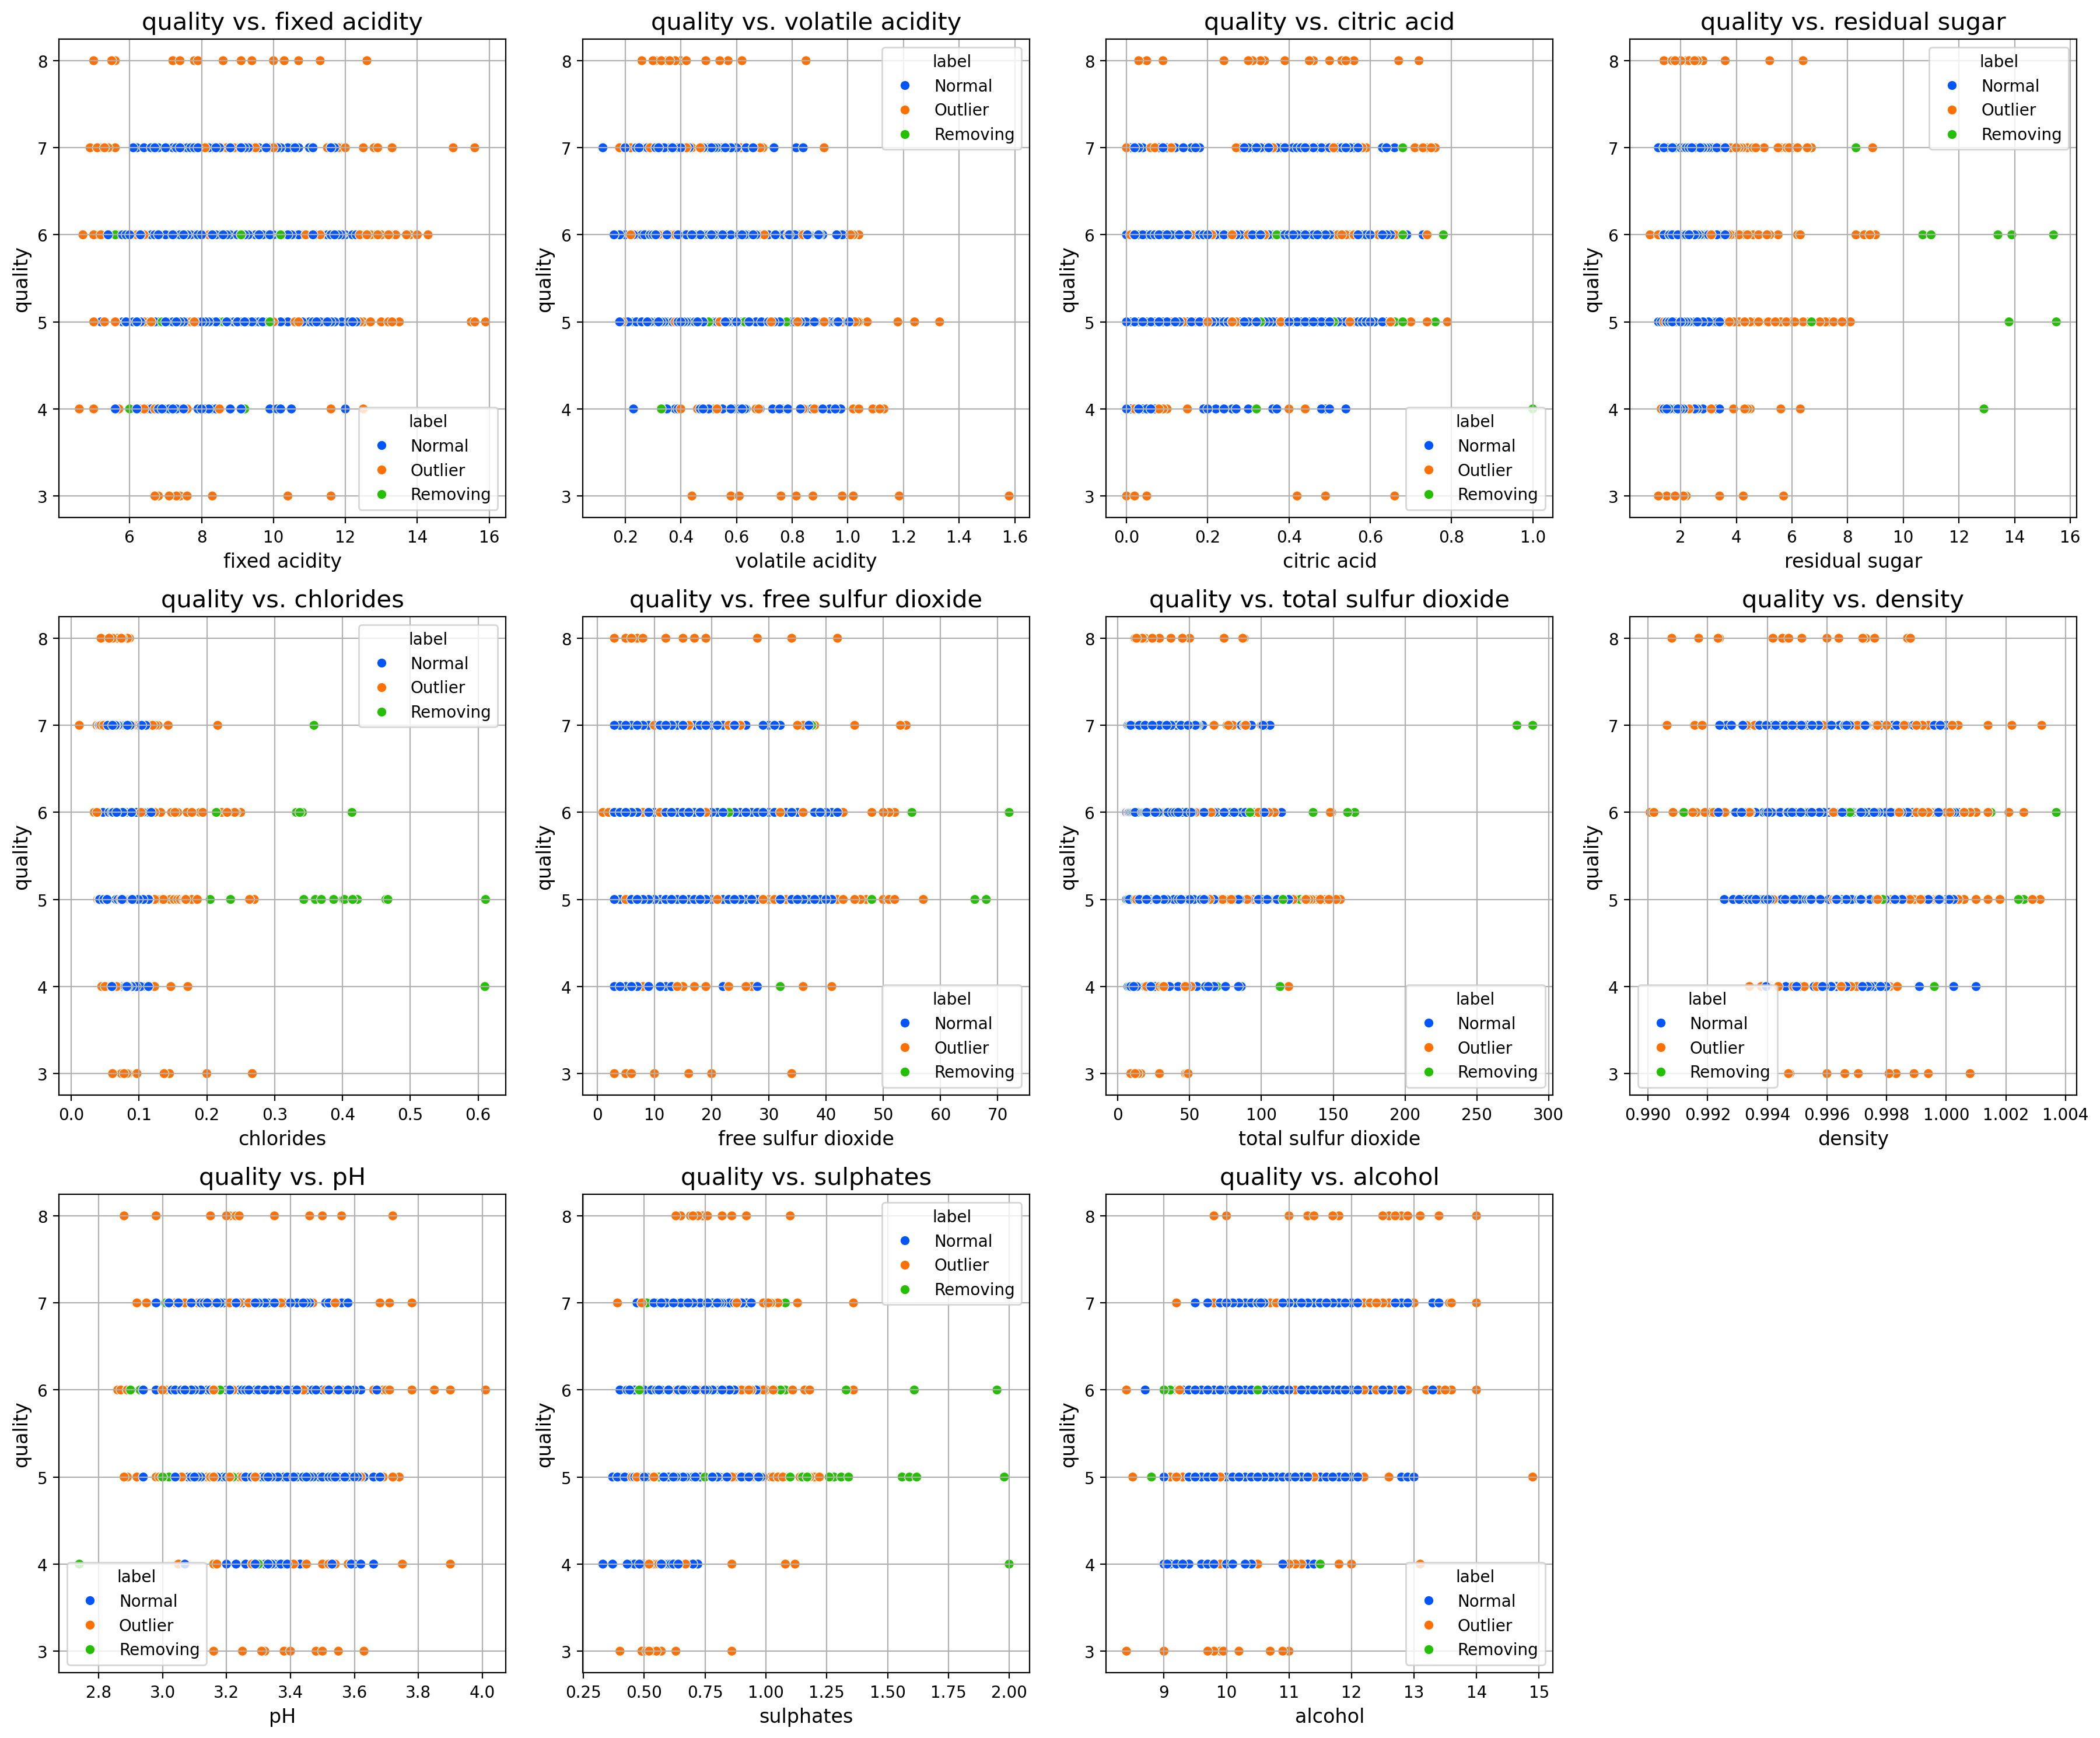

In [19]:
df1 = data.copy()

# 标记异常值和删除行
df1['label'] = 'Normal'
df1.loc[outliers_indexes, 'label'] = 'Outlier'

# 去除特定条件下的值
removing_indexes = []
removing_indexes.extend(df1[df1['residual sugar'] > 10].index)
removing_indexes.extend(df1[df1['chlorides'] > 0.3].index)
removing_indexes.extend(df1[df1['free sulfur dioxide'] > 60].index)
removing_indexes.extend(df1[df1['total sulfur dioxide'] > 160].index)
removing_indexes.extend(df1[df1['sulphates'] > 1.5].index)
df1.loc[removing_indexes, 'label'] = 'Removing'

# 获取特征列，去掉目标变量
target = 'quality'
features = data.columns.drop(target)

# 自定义调色板
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

# 动态计算子图的行列数
num_features = len(features)
ncols = 4  # 每行显示4个图
nrows = (num_features + ncols - 1) // ncols  # 根据特征数量动态计算行数

# 创建图形和子图
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), dpi=200)

# 绘制每个特征与目标变量之间的关系
for i, feature in enumerate(features):
    x = i // ncols  # 计算当前特征的行数
    y = i % ncols   # 计算当前特征的列数
    sns.scatterplot(data=df1, x=feature, y=target, hue='label', ax=ax[x, y], palette=CustomPalette)
    ax[x, y].set_title(f'{target} vs. {feature}', size=15)
    ax[x, y].set_xlabel(feature, size=12)
    ax[x, y].set_ylabel(target, size=12)
    ax[x, y].grid(True)
ax[2, 3].axis('off')
# 调整子图布局，避免重叠
plt.savefig("红酒质量-离群点去除.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()


In [21]:
removing_indexes = list(set(removing_indexes))

In [23]:
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

In [25]:
df1.shape

(1555, 13)

In [33]:
df = df1.drop('label',axis = 1)

In [35]:
df.to_csv("红酒质量-已清洗.csv", index=False)